# Harmonic splitter

Go through either experimental or simulation data to isolate the frequencies.

Outputs file "Smoothed.txt" which contains the smoothed current harmonics against time. Use this with CompareSmoothed to get the comparison metric - including weights 

## Interactive mode

This script is typically run in from a bash script without any user interaction. 
Set the following option to True if output and plots to screen are required.

In [31]:
plotInteractive = False

### Load packages

In [32]:
# import required python packages
import numpy as np
# load scipy for FFT functions
from scipy.fftpack import rfft, irfft, fftfreq
# load pandas for data frame manipulation for csv output
import pandas as pd
import sys

Double check that interactive plotting mode is disabled if running this in script mode

In [33]:
thisCodeName = 'HarmonicSplitter.py'
nLength = len(thisCodeName)
tailString = sys.argv[0]
tailString = tailString[-nLength:]
if(tailString==thisCodeName):
    plotInteractive = False

## Read settings

Read file names and parameters from settings file made by GenerateScript

In [34]:
lines = [line.rstrip('\n') for line in open('Settings.inp')]
filename = lines[0].strip().split()[0]
number_harmonics = int(lines[1].strip().split()[0])
frequency_bandwidth = float(lines[2].strip().split()[0])
iUseSingleMetric = int(lines[3].strip().split()[0])
i_use_weights = int(lines[4].strip().split()[0])
weights = np.fromstring(lines[5].strip(), dtype=float, sep=',')

## Define functions

Read the data file using the format from POT software also used as default by MECSim. Time, current then applied potential

In [35]:
# load POT output file
# t_MS2, i_MS2, e_MS2 = ReadPOTFile('Raw/GC06_FeIII-1mM_1M-KCl_02_009Hz.txt', tmin, tmax)
def ReadPOTFileFreq(filename):
    f = open(filename, 'r')
    time = []
    eapp = []
    current = []
    freq = []
    amp = []
    phase = []
    nfreq = 0
    iCount = 0
    iAll = 0
    for line in f:
        columns = line.split()
        if(columns[0][3:7].isdigit()): # look at 2nd character in case Eapp is "-"
            thisTime = float(columns[2])
            time.append(thisTime)
            eapp.append(float(columns[0]))
            current.append(float(columns[1]))
            iCount += 1
        else:
            if(columns[0][0:3]=='Fre'):
                freq.append(float(columns[1]))
            if(columns[0][0:3]=='Amp'):
                amp.append(float(columns[1]))
                if(amp[-1]!=0.0):
                    nfreq += 1
            if(columns[0][0:3]=='Pha'):
                phase.append(float(columns[1])) # not always there
        iAll += 1
    return iCount, nfreq, freq, amp, time, current, eapp

Smooth the current as an envelope of the current as a function of time

In [36]:
def SmoothCurrent(t, i, e, tWindow):
    iSmooth = list(i)
    deltaT = t[1]-t[0] # assumes constant time steps
    tEnd = t[-1]
    tStart = t[0]
    iWindow = int(tWindow/deltaT)+1
    windowVal = []
    iMax = len(t)
    iMinW = -iWindow/2
    iMaxW = iMinW+iWindow-1
    for j in range(0, iWindow):
        windowVal.insert(0, i[j]) # insert at top/pop from bottom
    for ii in range(iMax):
        iMinW += 1
        iMaxW += 1
        if((iMinW>0) and (iMaxW<iMax)): # shift running total across by one point
            windowVal.pop()
            windowVal.insert(0, i[iMaxW])
        iSmooth[ii] = max(windowVal)
    return iSmooth

## Read data file

Critical values to return are: nfreq, freq, time, current, eapp. Can ignore: iCount, amp


In [37]:
iCount, nfreq, freq, amp, time, current, eapp = ReadPOTFileFreq(filename)
t = np.array(time)
c = np.array(current)
ea = np.array(eapp)

Isolate ac fundamental frequencies
---

In [38]:
if(nfreq>0):
    # dc + ac harmonics
    freqMin = min(freq[0:nfreq])
else:
    # dc only
    freqMin = 1000.
    number_harmonics = 0
# set time period for FFT cuts
tWindow = 1.0/freqMin
# output if in interactive mode
if(plotInteractive):
    print('f_min = ',freqMin,' ; t_window = ',tWindow, ' ; n_harmonics (dc=0th) = ', number_harmonics)

('f_min = ', 9.001233, ' ; t_window = ', 0.11109589097404768, ' ; n_harmonics (dc=0th) = ', 5)


FFT of the time series data
---

Single frequency is assumed for now. Do all harmonics of it (and dc).

Some error catching added for cases without any frequencies.

DC will now take the FFT with $f<f_{min}$ for cases with harmonics or $f_{min}$ = 1000 Hz equivalent if DC only.

In [39]:
i_Harm = []
c_Harm = []
e_dc = []

# also do for the e_app (remove ac component from this)
W = fftfreq(ea.size, d=2*(t[1]-t[0]))
f_signal = rfft(ea)
cut_f_signal = f_signal.copy()
cut_f_signal[(W>0.5*freqMin)] = 0
cut_signal = irfft(cut_f_signal)
e_dc.append(cut_signal)

e_dc = np.array(e_dc).reshape(len(t))

# special treatment for dc (harmonic = 0)
W = fftfreq(c.size, d=2*(t[1]-t[0]))
f_signal = rfft(c)
cut_f_signal = f_signal.copy()
cut_f_signal[(W>0.5*freqMin)] = 0
cut_signal = irfft(cut_f_signal)
c_Harm.append(cut_signal)
i_Harm.append(SmoothCurrent(t, cut_signal, eapp, tWindow))

# save FFT for DC to use in interactive plot
W_dc = W.copy()
f_signal_dc = f_signal.copy()
cut_f_signal_dc = cut_f_signal.copy()
cut_signal_dc = cut_signal.copy()

# frequency based harmonics (n*freq)
for iH in range(number_harmonics):
    iHarm = iH + 1
    fH = float(iHarm)
    W = fftfreq(c.size, d=2*(t[1]-t[0]))
    f_signal = rfft(c)
    cut_f_signal = f_signal.copy()
    cut_f_signal[(W<(fH*freq[0]-frequency_bandwidth))] = 0
    cut_f_signal[(W>(fH*freq[0]+frequency_bandwidth))] = 0
    cut_signal = irfft(cut_f_signal)
    c_Harm.append(cut_signal)
    i_Harm.append(SmoothCurrent(t, cut_signal, eapp, tWindow))


## Save harmonic data

Use Python Data Analysis (pandas) library to slice data and add time as first column for csv output

In [40]:
output_df = pd.DataFrame(i_Harm)
output_df = output_df.transpose()
# add Eapp at the start
output_df.insert(loc=0, column='ea', value=ea)
# add e_dc before Eapp
output_df.insert(loc=0, column='e_dc', value=e_dc)
# add time at the start (so cols = t, e_dc, e_app, i...)
output_df.insert(loc=0, column='t', value=t)

Output modified data frame to csv file. Will be read and compared to experimental counterpart by CompareSmoothed.py

In [41]:
np.savetxt( 'Smoothed.txt', output_df)

## Use interactive plotter

ONLY if not using this in bash script

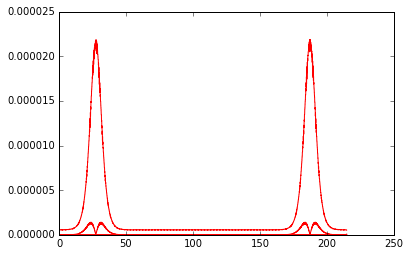

In [42]:
if(plotInteractive):
    import matplotlib.pyplot as plt
    %matplotlib inline
    for i in range(number_harmonics):
        iH = i+1
        plt.plot(t, i_Harm[iH],c='r')
    if(number_harmonics>1):
        plt.show()

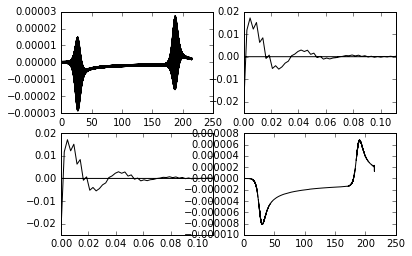

In [43]:
# plot the dc component
if(plotInteractive):
    plt.subplot(221)
    plt.plot(t, c, 'k')
    plt.subplot(222)
    plt.plot(W_dc, f_signal_dc, 'k')
    plt.xlim(0, tWindow)
    plt.subplot(223)
    plt.plot(W_dc, cut_f_signal_dc, 'k')
    plt.xlim(0,tWindow)
    plt.subplot(224)
    plt.plot(t, cut_signal_dc, 'k')
    plt.show()
    

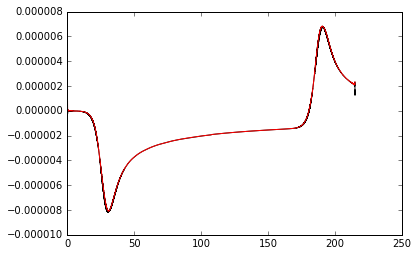

In [44]:
if(plotInteractive):
    iH = 0
    plt.plot(t, c_Harm[iH],c='k')
    plt.plot(t, i_Harm[iH],c='r')
    plt.show()

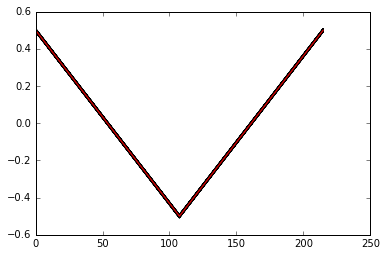

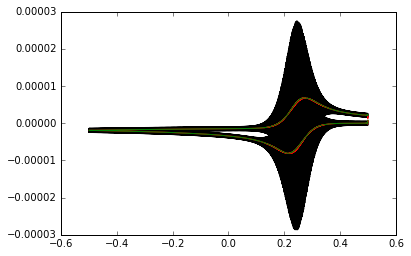

In [45]:
if(plotInteractive):
    iH = 0
    plt.plot(t, ea,c='k')
    plt.plot(t, e_dc,c='r')
    plt.show()
    plt.plot(e_dc, c,c='k')
    plt.plot(e_dc, c_Harm[iH],c='r')
    plt.plot(e_dc, i_Harm[iH],c='g')
    plt.show()